## Sensitivity analysis for a linear shallow water simulation of the 2011 Tohoku tsunami

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from thetis import *
from firedrake_adjoint import *

In [3]:
from adapt_utils.case_studies.tohoku.options import TohokuOptions

Misc plotting routines

In [4]:
def plot_mesh(mesh2d, axes=None):
    if axes is None:
        fig, axes = plt.subplots(figsize=(6, 6))
    triplot(mesh2d, axes=axes);
    axes.axis(False);
    axes.legend(loc='upper left');
    return axes

In [21]:
def plot_field(field, figure=None, axes=None, height=5, **kwargs):
    CG1 = field.ufl_element().degree() == 1 and field.ufl_element().family() == 'Lagrange'
    fs_constructor = FunctionSpace if len(field.function_space().shape) == 0 else VectorFunctionSpace
    out = field if CG1 else interpolate(field, fs_constructor(field.function_space().mesh(), "CG", 1))
    
    if figure is None and axes is None:
        figure, axes = plt.subplots(figsize=(height*1.2, height))
    if axes is None:
        axes = plt.gca()
    figure.colorbar(tricontourf(out, levels=50, axes=axes, cmap='coolwarm', **kwargs), ax=axes);
    axes.axis(False);
    axes.set_title(field.dat.name);
    return axes

In [6]:
def plot_fields(*fields, height=5):
    nfields = len(fields)
    fig, axes = plt.subplots(ncols=nfields, figsize=(height*nfields*1.2, height))
    for i, field in enumerate(fields):
        plot_field(field, fig, axes[i])
    return axes

Define a mesh and a Taylor-Hood space upon it. Note that the boundary is separated into three segments $\Gamma_{100}$, $\Gamma_{200}$ and $\Gamma_{300}$ corresponding to the (artificial) ocean boundary, coastal regions outside the locality of Fukushima and coastal regions near to Fukushima, respectively.

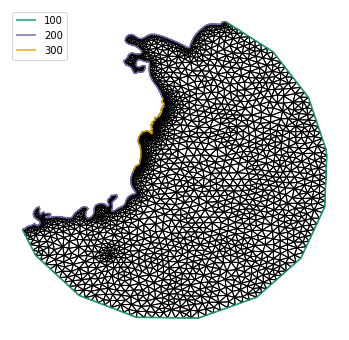

In [7]:
op = TohokuOptions(end_time=60.0)
mesh = op.default_mesh
P2_vec = VectorFunctionSpace(mesh, "CG", 2)
P1 = FunctionSpace(mesh, "CG", 1)
TaylorHood = P2_vec*P1
plot_mesh(mesh);

Define necessary fields

* Initial surface computed via inversion analysis in __[Saito et al. 2011]__.
* Bathymetry from GEBCO.

In [16]:
eta_init = Function(P1, name="Initial surface").assign(op.initial_surface)
kernel = Function(TaylorHood).assign(op.set_qoi_kernel(TaylorHood))
kernel_eta = kernel.split()[1]
kernel_eta.dat.name = "Kernel function"
b = Function(P1, name="Bathymetry").assign(op.bathymetry)
g = Constant(op.g)
f = Function(P1, name="Coriolis parameter").assign(op.set_coriolis(P1))

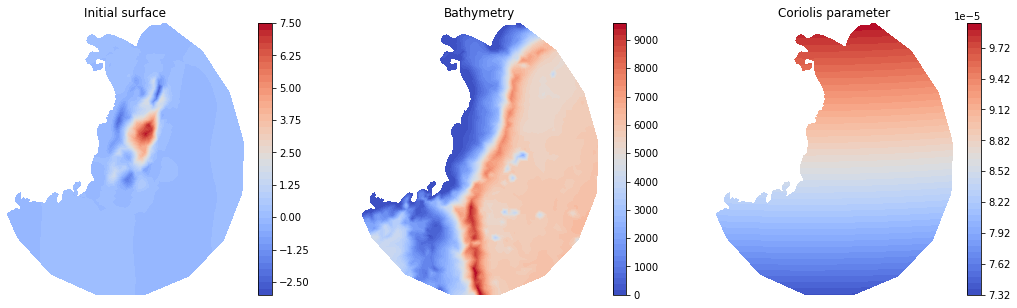

In [9]:
plot_fields(eta_init, b, f);

Hand-coded Taylor-Hood solver for shallow water equations linearised about lake at rest:

$$
    \frac{\partial\mathbf u}{\partial t}+g\nabla\eta+f\widehat{\mathbf z}\times\mathbf u=\boldsymbol0,\qquad
    \frac{\partial\eta}{\partial t}+\nabla\cdot(b\mathbf u)=0
$$
equipped with boundary conditions
$$
    \mathbf u\cdot\widehat{\mathbf n}|_{\partial\Omega}\equiv0\qquad
    \eta|_{\Gamma_{100}}\equiv0.
$$

In [10]:
dtc = Constant(op.dt)

u, eta = TrialFunctions(TaylorHood)
z, zeta = TestFunctions(TaylorHood)

w_ = Function(TaylorHood)
u_, eta_ = w_.split()
eta_.assign(eta_init)
control = Control(w_)

a = inner(z, u)*dx + inner(zeta, eta)*dx
L = inner(z, u_)*dx + inner(zeta, eta_)*dx

def G(f0, f1):
    F = g*inner(z, grad(f1))*dx
    F += f*inner(z, as_vector((-f0[1], f0[0])))*dx
    F += -inner(grad(zeta), b*f0)*dx
    return F

a += 0.5*dtc*G(u, eta)
L += -0.5*dtc*G(u_, eta_)

w = Function(TaylorHood)
u, eta = w.split()
eta.dat.name = "Final surface"

bc = DirichletBC(TaylorHood.sub(1), 0, 100)

params = {
    "snes_type": "ksponly",
    "ksp_type": "gmres",
    "pc_type": "fieldsplit",
    "pc_fieldsplit_type": "multiplicative",
}

problem = LinearVariationalProblem(a, L, w, bcs=bc)
solver = LinearVariationalSolver(problem, solver_parameters=params)

Consider a time-dependent quantity of interest (QoI):
$$
J(\mathbf u,\eta)=\int_{T_{\mathrm{start}}}^{T_{\mathrm{end}}}\int_\Omega k\eta\;\mathrm dx\;\mathrm dt,
$$
where $k$ is the kernel function plotted above, focused around Fukushima.
Here $T_{\mathrm{start}}$ is to be chosen and $T_{\mathrm{end}}$ is the simulation end time (24 minutes).
We are going to solve the linear shallow water equations and compute the sensitivities of this QoI to the initial condition.

First, choose $T_{\mathrm{start}}$ to be 15 minutes.

In [11]:
t = 0.0
i = 0
J = 0
while t < op.end_time + 0.5*op.dt:
    if i % 20 == 0:
        print("t = {:.2f}".format(t))
    solver.solve()
    
    # Time integrate QoI
    #   NOTE: The quadrature scheme matching Crank-Nicolson is the trapezium rule
    if t > op.start_time:
        weight = 1.0
        if t <= op.start_time + 0.5*op.dt or t >= op.end_time - 0.5*op.dt:
            weight = 0.5
        J += weight*op.dt*assemble(inner(kernel, w)*dx)
        
    w_.assign(w)
    t += op.dt
    i += 1
print("Quantity of interest = {:.4e}".format(J))

# Compute gradient w.r.t. initial condition
with stop_annotating():
    dJdic = compute_gradient(J, control)
    dJdic_u, dJdic_eta = dJdic.split()
    dJdic_u.dat.name = "Sensitivity of QoI to initial velocity"
    dJdic_eta.dat.name = "Sensitivity of QoI to initial surface"

t = 0.00
t = 100.00
t = 200.00
t = 300.00
t = 400.00
t = 500.00
t = 600.00
t = 700.00
t = 800.00
t = 900.00
t = 1000.00
t = 1100.00
t = 1200.00
t = 1300.00
t = 1400.00
Quantity of interest = -7.7929e+10


Compare initial and final solution

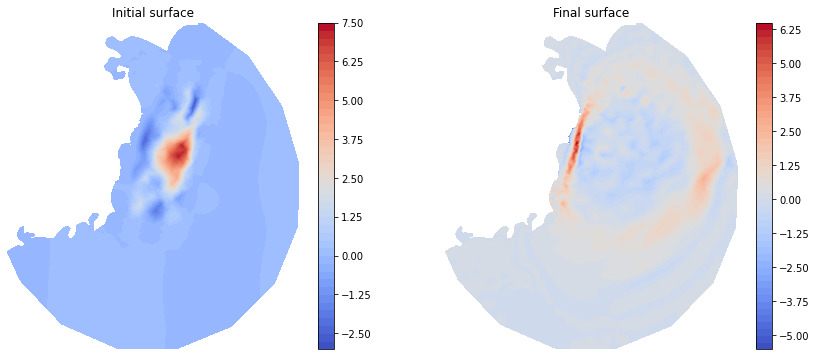

In [20]:
axes = plot_fields(eta_init, eta, height=6)

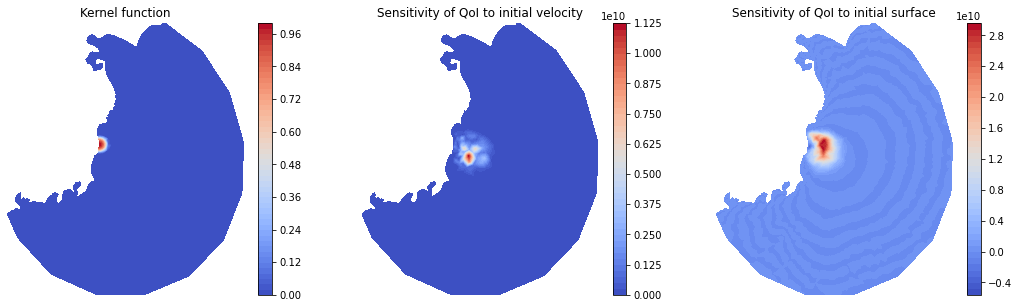

In [16]:
plot_fields(kernel_eta, dJdic_u, dJdic_eta);

### What do these plots tell us?

Focus on the final plot, which corresponds to $\frac{\mathrm dJ}{\mathrm d\eta_0}$.
This conveys the sensitivity of the QoI to the initial surface across different parts of the domain.
* In most of the domain, we observe this gradient to be small. This indicates that perturbations in the initial condition in these regions have little effect upon the QoI value.
* In and surrounding the region of interest, the gradient takes significantly large values. This is particularly true on the approach to the region of interest. We observe that the QoI value is actually insensitive to perturbations in the northern part of the initial surface profile. This is in agreement to the fact that (in the eyeball norm) the tsunami's trajectory was mostly directly toward the east coast of Japan, perpendicular to the intercontinental shelf break.

Let's look a bit closer at the final sensitivity plot.

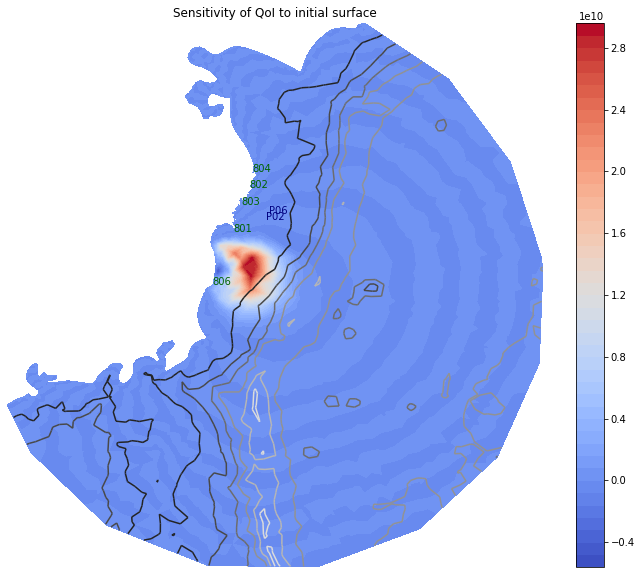

In [28]:
axes = plot_field(dJdic_eta, height=10)
op.annotate_plot(axes, gauges=True, coords="utm")
tricontour(b, axes=axes, cmap='gray');

Observe that neither of the pressure gauges P02 or P06, nor any of the GPS gauges 801-804 lie within this region of sensitivity.
However, gauge 806 is right in the middle of it.
Sadly, our fixed mesh runs so far haven't done all too well at capturing this particular timeseries:

Plotting timeseries for gauge 806...


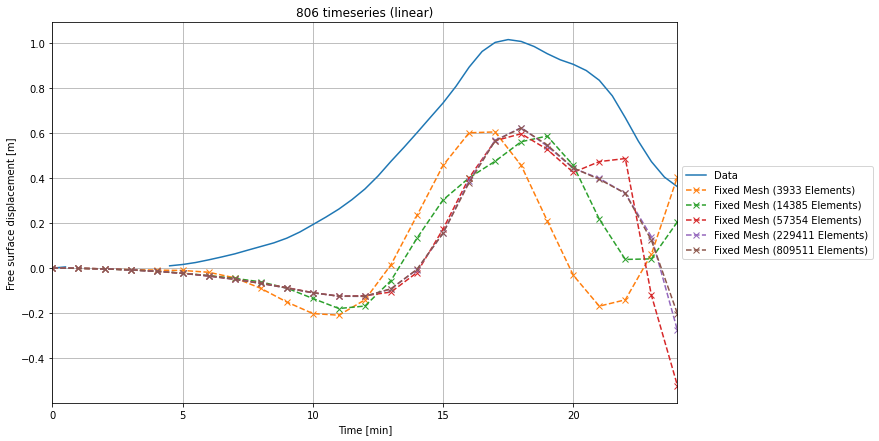

In [9]:
fig, axes = plt.subplots(figsize=(14, 7))
op.plot_timeseries("806", sample=30, axes=axes)

This is probably because we are using linearised shallow water equations with simplistic free-slip boundaries at the coast.
Perhaps we need to upgrade to a nonlinear model with wetting and drying, or the dispersive tsunami equations which were used in the inversion for the initial free surface.

In [13]:
get_working_tape().clear_tape()

Let's do the computation again but with $T_{\mathrm{start}}$ set to the start of the simulation ($t=0$).

In [18]:
op.start_time = 0.0

In [14]:
eta_init = Function(P1, name="Initial surface").assign(op.initial_surface)
kernel = Function(TaylorHood).assign(op.set_qoi_kernel(TaylorHood))
b = Function(P1, name="Bathymetry").assign(op.bathymetry)
f = Function(P1, name="Coriolis parameter").assign(op.set_coriolis(P1))

In [17]:
dtc = Constant(op.dt)

u, eta = TrialFunctions(TaylorHood)
z, zeta = TestFunctions(TaylorHood)

w_ = Function(TaylorHood)
u_, eta_ = w_.split()
eta_.assign(eta_init)
control = Control(w_)

a = inner(z, u)*dx + inner(zeta, eta)*dx
L = inner(z, u_)*dx + inner(zeta, eta_)*dx

def G(f0, f1):
    F = g*inner(z, grad(f1))*dx
    F += f*inner(z, as_vector((-f0[1], f0[0])))*dx
    F += -inner(grad(zeta), b*f0)*dx
    return F

a += 0.5*dtc*G(u, eta)
L += -0.5*dtc*G(u_, eta_)

w = Function(TaylorHood)
u, eta = w.split()
eta.dat.name = "Final surface"

bc = DirichletBC(TaylorHood.sub(1), 0, 100)

params = {
    "snes_type": "ksponly",
    "ksp_type": "gmres",
    "pc_type": "fieldsplit",
    "pc_fieldsplit_type": "multiplicative",
}

problem = LinearVariationalProblem(a, L, w, bcs=bc)
solver = LinearVariationalSolver(problem, solver_parameters=params)

In [19]:
t = 0.0
i = 0
J = 0
while t < op.end_time + 0.5*op.dt:
    if i % 20 == 0:
        print("t = {:.2f}".format(t))
    solver.solve()
    
    # Time integrate QoI
    #   NOTE: The quadrature scheme matching Crank-Nicolson is the trapezium rule
    if t > op.start_time:
        weight = 1.0
        if t <= op.start_time + 0.5*op.dt or t >= op.end_time - 0.5*op.dt:
            weight = 0.5
        J += weight*op.dt*assemble(inner(kernel, w)*dx)
        
    w_.assign(w)
    t += op.dt
    i += 1
print("Quantity of interest = {:.4e}".format(J))

# Compute gradient w.r.t. initial condition
with stop_annotating():
    dJdic = compute_gradient(J, control)
    dJdic_u, dJdic_eta = dJdic.split()
    dJdic_u.dat.name = "Sensitivity of QoI to initial velocity"
    dJdic_eta.dat.name = "Sensitivity of QoI to initial surface"

t = 0.00
t = 100.00
t = 200.00
t = 300.00
t = 400.00
t = 500.00
t = 600.00
t = 700.00
t = 800.00
t = 900.00
t = 1000.00
t = 1100.00
t = 1200.00
t = 1300.00
t = 1400.00
Quantity of interest = -2.2921e+11


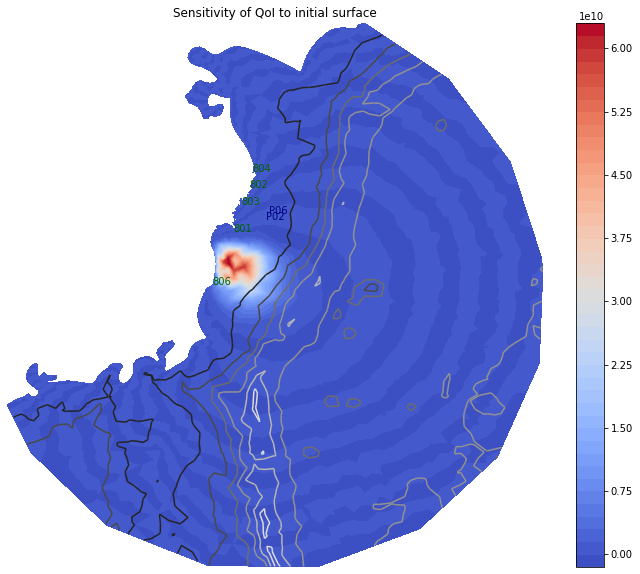

In [26]:
axes = plot_field(dJdic_eta, height=10)
op.annotate_plot(axes, gauges=True, coords="utm")
tricontour(b, axes=axes, cmap='gray');